In [16]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import pickle
from tqdm import tqdm

In [2]:
image_vec_shape = 12
gait_key_poses = 16
conditional_vec_shape = 10
pose_image_shape = (160,120,1)
batch_size = 15
full_vec_shape = image_vec_shape+conditional_vec_shape
n_timesteps = 3

In [3]:
model_OneRNN = keras.models.Sequential()
model_BiRNN = keras.models.Sequential()
model_ConvRNN = keras.models.Sequential()

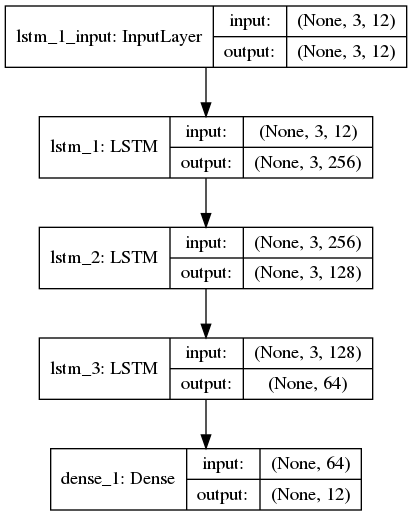

In [4]:
model_OneRNN = keras.models.Sequential()
model_OneRNN.add(keras.layers.LSTM(256,
                                   activation='tanh',
                                   return_sequences=True,
                                   input_shape=(n_timesteps,
                                                image_vec_shape)
                                  ))
#model_OneRNN.add(keras.layers.LSTM(256,
#                                   activation='tanh',
#                                   return_sequences=True
#                                  ))
model_OneRNN.add(keras.layers.LSTM(128,
                                   activation='tanh',
                                   return_sequences=True
                                  ))
model_OneRNN.add(keras.layers.LSTM(64,
                                   activation='tanh'
                                  ))
model_OneRNN.add(keras.layers.Dense(image_vec_shape,
                                    activation='linear'
                                  ))
model_OneRNN.compile(optimizer='adam', loss='mse')
plot_model(model_OneRNN, to_file='model_OneRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_OneRNN_plot.png')
im

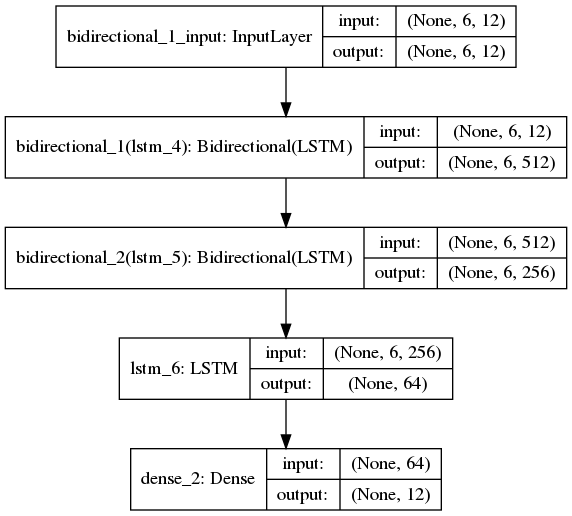

In [5]:
model_BiRNN = keras.models.Sequential()
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(256,
                                      activation='tanh',
                                      return_sequences=True),
                                      input_shape=(2*n_timesteps,image_vec_shape)
                ))
model_BiRNN.add(keras.layers.Bidirectional(
                    keras.layers.LSTM(128,
                                      activation='tanh',
                                      return_sequences=True)
                ))
model_BiRNN.add(keras.layers.LSTM(64,
                                  activation='tanh'
                                 ))
model_BiRNN.add(keras.layers.Dense(image_vec_shape))
model_BiRNN.compile(optimizer='adam', loss='mse')
plot_model(model_BiRNN, to_file='model_BiRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_BiRNN_plot.png')
im

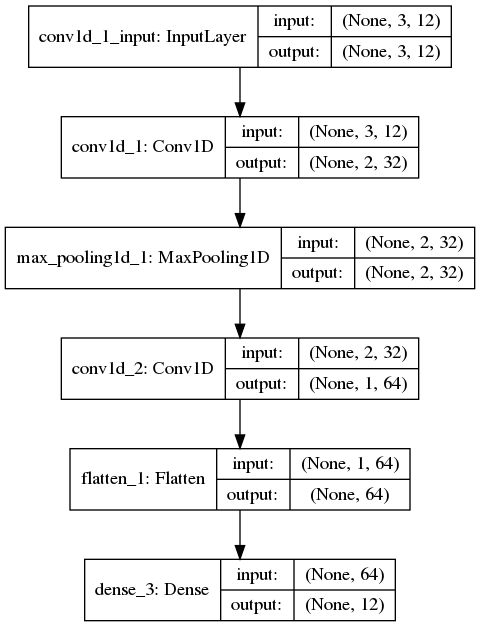

In [6]:
model_ConvRNN = keras.models.Sequential()
model_ConvRNN.add(keras.layers.Conv1D(filters=32,
                                        kernel_size = 2,
                                        activation='tanh',
                                        input_shape=(n_timesteps, image_vec_shape)
                                     ))
model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=1))
model_ConvRNN.add(keras.layers.Conv1D(filters=64,
                                      kernel_size= 2,
                                      activation='tanh'))
#model_ConvRNN.add(keras.layers.MaxPooling1D(pool_size=2))
model_ConvRNN.add(keras.layers.Flatten())
model_ConvRNN.add(keras.layers.Dense(image_vec_shape))
model_ConvRNN.compile(optimizer='adam', loss='mse')
plot_model(model_ConvRNN, to_file='model_ConvRNN_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_ConvRNN_plot.png')
im

In [7]:
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(15, image_vec_shape), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.)*eps
def encoder_model():
    x_in = keras.layers.Input(name="x_image",
                              shape=pose_image_shape)
    condition_in = keras.layers.Input(name="condition_hotshot",
                                      shape=(gait_key_poses,))
    condi_vec1 = keras.layers.Dense(8,activation='relu',name="condition_dense_1")(condition_in)
    condi_vec = keras.layers.Dense(4,activation='relu',name="condition_dense_2")(condi_vec1)
    x = keras.layers.Conv2D(filters=16,
                            kernel_size=(7,7),
                            strides=(3,3),
                            activation='relu',
                            name="x_conv_1")(x_in)
    x = keras.layers.BatchNormalization(name="x_batch_norm_1")(x,training=True)
    x = keras.layers.Conv2D(filters=32,
                            kernel_size=(7,7),
                            strides=(3,3),
                            activation='relu',
                            name="x_conv_2")(x)
    x = keras.layers.BatchNormalization(name="x_batch_norm_2")(x, training=True)
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(5,5),
                            strides=(2,2),
                            activation='relu',
                            name='x_conv_3')(x)
    x = keras.layers.BatchNormalization(name="x_batch_norm_3")(x, training=True)
    x = keras.layers.Flatten(name="x_flatten")(x)
    x = keras.layers.Dense(336, activation='relu',name="x_dense_final")(x)
    x_vec = keras.layers.concatenate([x,condi_vec], name="concat_xvec")
    x_vec = keras.layers.Dense(32, activation='relu',name="xvec_dense_final")(x_vec)
    mu = keras.layers.Dense(image_vec_shape, activation='linear',name="mu_dense")(x_vec)
    log_var = keras.layers.Dense(image_vec_shape, activation='linear', name="logvar_dense")(x_vec)
    z = keras.layers.Lambda(sampling, output_shape=(image_vec_shape,), name="lambda_sampling")([mu,log_var])
    z_cond = keras.layers.concatenate([z, condi_vec],name="concat_zcond")
    
    encoder = keras.models.Model([x_in,condition_in], z_cond)
    
    z1 = keras.layers.Dense(32, activation='relu', name="z_dense_1")(z_cond)
    z1 = keras.layers.Dense(336, activation='relu', name="z_dense_2")(z1)
    z1 = keras.layers.Dense(1536, activation='relu', name="z_dense_3")(z1)
    zim = keras.layers.Reshape((6,4,64),name="reshape_image")(z1)
    zim = keras.layers.Conv2DTranspose(filters=32,
                                       kernel_size=(5,5),
                                       strides=(2,2),
                                       activation='relu',
                                       name="z_convT_1")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_1")(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=16,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_2")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_2")(zim, training=True)
    zim = keras.layers.Conv2DTranspose(filters=3,
                                       kernel_size=(7,7),
                                       strides=(3,3),
                                       activation='relu',
                                       name="z_convT_3")(zim)
    zim = keras.layers.Dropout(0.1, name="z_dropout_3")(zim, training=True)
    y = keras.layers.Conv2D(filters=1,
                            kernel_size=(2,2),
                            activation='tanh',
                            name="image_out")(zim)
    
    #decoder = keras.models.Model(z_cond_in, y)
    full_model = keras.models.Model([x_in, condition_in], y)
    
    reconstruction_loss = keras.losses.binary_crossentropy(x_in, y)*pose_image_shape[0]*pose_image_shape[1]
    kl_loss = 0.5*K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis=-1)
    cvae_loss = reconstruction_loss + kl_loss
    
    full_model.add_loss(cvae_loss)
    full_model.compile(optimizer='adam', loss=None)
    ## Ignore the missing from loss dictionary error
    return encoder, full_model
CVAE, CVAE_FULL = encoder_model()

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Output "image_out" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "image_out" during training.


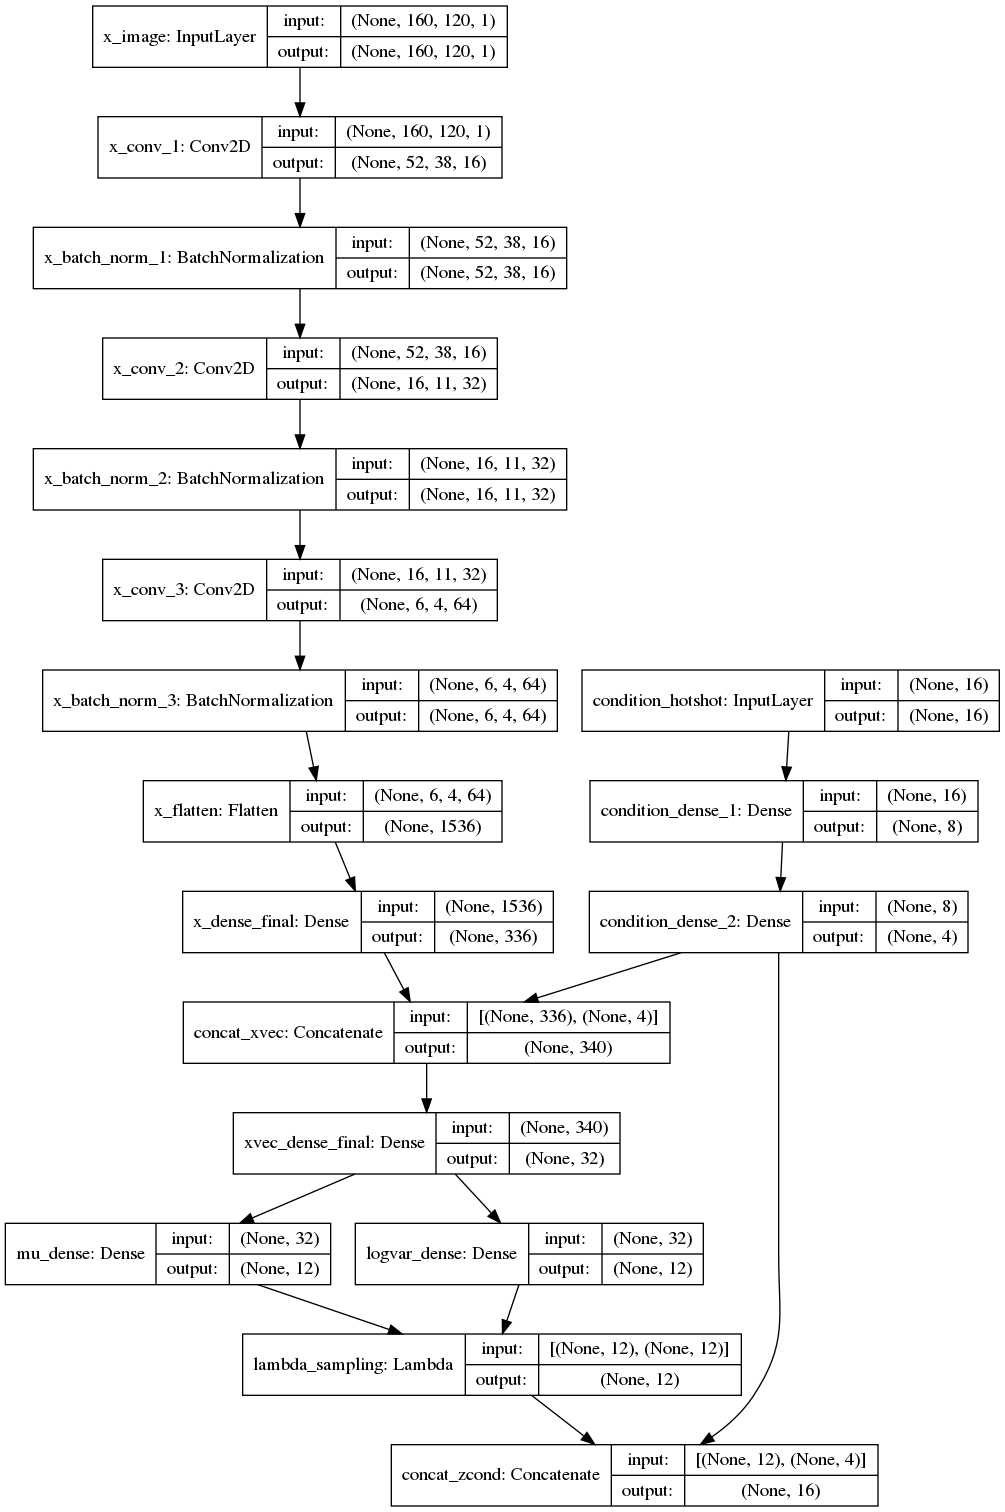

In [8]:
plot_model(CVAE, to_file='CVAE.png', show_shapes=True, show_layer_names=True)
im = Image.open('CVAE.png')
im

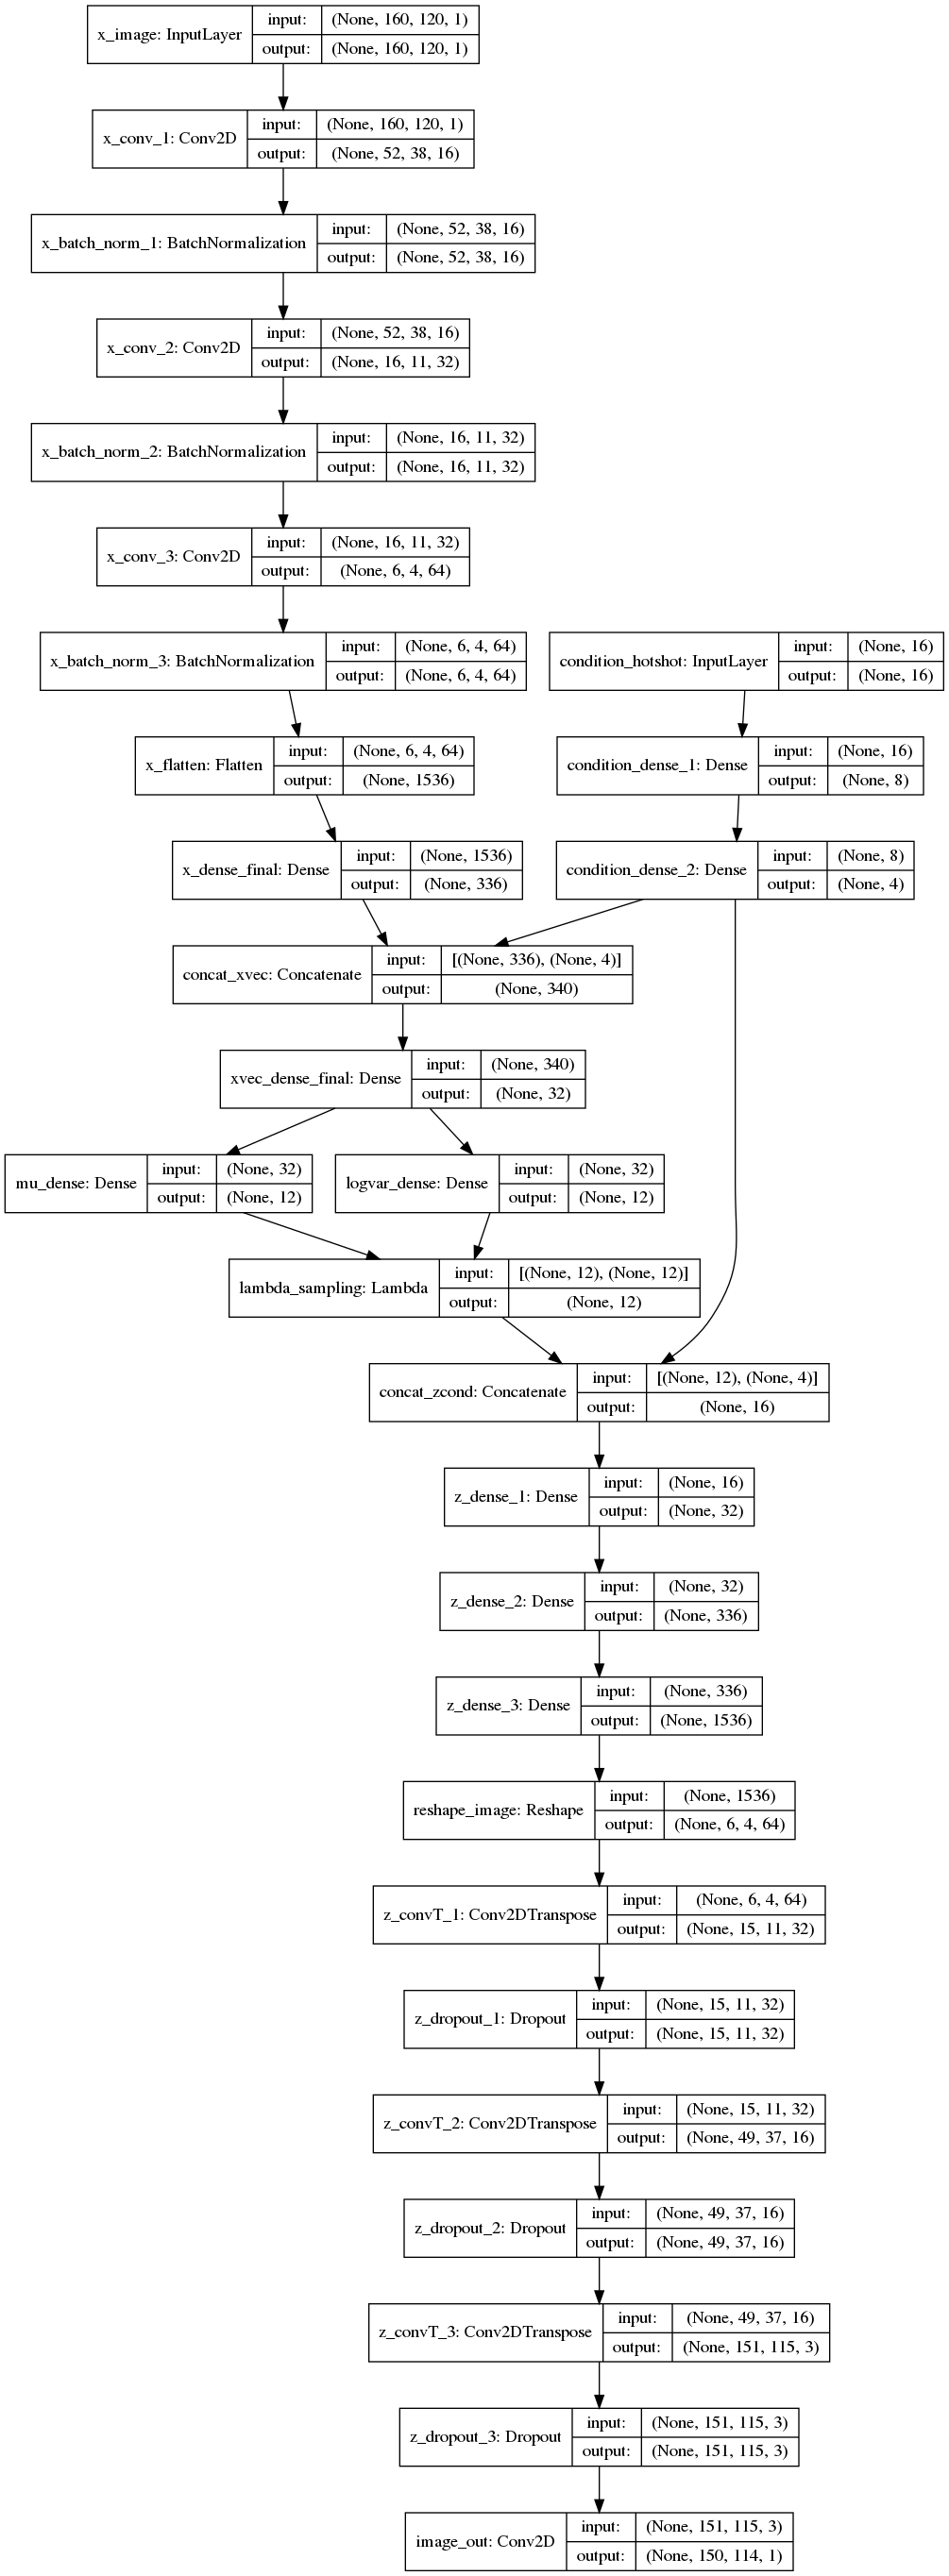

In [9]:
plot_model(CVAE_FULL, to_file='CVAE_FULL.png', show_shapes=True, show_layer_names=True)
im = Image.open('CVAE_FULL.png')
im

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, files, labels, preprocess=None, batch_size = 15, dim=(160,120), n_channels=1, n_classes=16, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.files = files
        self.preprocess = preprocess or (lambda x : x)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        files_temp = [self.files[k] for k in indexes]
        
        X,y = self.__data_generation(files_temp)
        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, files_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size),dtpye=int)
        for i,file in enumerate(files_temp):
            X[i,] = self.preprocess(cv2.imread(file))
            y[i]=self.labels[file]
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [15]:
labels = {}
for folder in tqdm(sorted(os.listdir(os.getcwd()+'/GaitDatasetB-silh'))):
    for subfolder in sorted(os.listdir('/'.join([os.getcwd(), 'GaitDatasetB-silh', folder]))):
        for angle in sorted(os.listdir('/'.join([os.getcwd(), 'GaitDatasetB-silh',folder,subfolder]))):
            label_file = '/'.join([os.getcwd(),'GaitDatasetB-silh',folder,subfolder,angle,'labels.pkl'])
            if os.path.isfile(label_file):
                labels_temp = pickle.load(open(label_file, 'rb'))
                for file in sorted(os.listdir('/'.join([os.getcwd(),'GaitDatasetB-silh', folder, subfolder, angle]))):
                    if file[-3:]!="pkl":
                        labels['/'.join([os.getcwd(),'GaitDatasetB-silh',folder,subfolder,angle,file])] = labels_temp[file]
np.savez_compressed('labels',**labels)

KeyboardInterrupt: 

KeyboardInterrupt: 